In [1]:
import numpy as np
import torch
from torchvision import transforms, utils
from torch.optim import SGD
from torch.optim.lr_scheduler import CosineAnnealingLR
import os
from pathlib import Path

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device: ', device)

from quantnn.qrnn import QRNN
from quantnn.models.pytorch import BatchedDataset

import sys
sys.path.append('../src')
from models.singles_fc import Net

/home/ingrid/anaconda3/envs/geostat/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729062494/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


device:  cpu


In [2]:
# SETUP
channels = list(range(8,17))
channels.remove(12)

fillvalue = -1

quantiles = np.linspace(0.01, 0.99, 99)

In [3]:
path_to_data = '../dataset/data/dataset-singles/'
X_train = np.load(path_to_data+'train/X_singles_dataset.npy')
y_train = np.load(path_to_data+'train/y_singles_dataset.npy')
X_val = np.load(path_to_data+'validation/X_singles_dataset.npy')
y_val = np.load(path_to_data+'validation/y_singles_dataset.npy')

def Standardize(X, path_to_data):
    stats = np.load(path_to_data+'train/X_singles_stats.npy')
    return (X-stats[0,:])/stats[1,:].astype(np.float32)
    
X_train = Standardize(X_train, path_to_data).astype(np.float32)
X_val = Standardize(X_val, path_to_data).astype(np.float32)

In [4]:
qrnn_fc = QRNN.load('../results/saved_models/hej2')

In [5]:
validation_data = BatchedDataset((X_val, y_val), 32)

y_true = []
y_pred_fc = []
for x, y in validation_data:
  y_true += [y.detach().numpy()]
  y_pred_fc += [qrnn_fc.posterior_mean(x=x).cpu().detach().numpy()]
y_true = np.concatenate(y_true, axis=0)
y_pred_fc = np.concatenate(y_pred_fc, axis=0)


In [6]:
bins = np.logspace(-2, 2, 100)
indices = y_true >= 0.0
freqs_fc, _, _ = np.histogram2d(y_true[indices], y_pred_fc[indices], bins=bins)

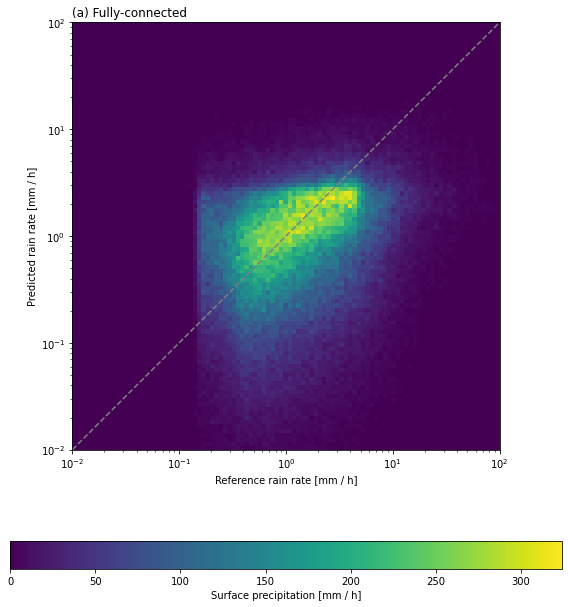

In [7]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
#norm = Normalize(0, 400)

f, ax = plt.subplots(figsize=(8, 9))


p = ax.pcolormesh(bins, bins, freqs_fc.T, 
              #norm=norm
             )
ax.set_xlim([1e-2, 1e2])
ax.set_ylim([1e-2, 1e2])
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Reference rain rate [mm / h]")
ax.set_ylabel("Predicted rain rate [mm / h]")
ax.set_title("(a) Fully-connected", loc="left")
ax.plot(bins, bins, c="grey", ls="--")
f.colorbar(p, ax=ax, orientation="horizontal", label="Surface precipitation [mm / h]")
ax.set_aspect(1.0)


plt.tight_layout()

In [8]:
print('Non zero rain to all rain ratio (true): ', np.sum(y_true[indices]!=0.)/len(y_true[indices]))
print('Non zero rain to all rain ratio (pred): ', np.sum(y_pred_fc[indices]!=0.)/len(y_pred_fc[indices]))

TP = np.sum(y_pred_fc[indices][(y_true[indices]!=0.)]!=0.)
print('TP: ', TP)
FN = np.sum(y_pred_fc[indices][(y_true[indices]!=0.)]==0.)
print('FN: ', FN)
FP = np.sum(y_pred_fc[indices][(y_true[indices]==0.)]!=0.)
print('FP: ', FP)
TN = np.sum(y_pred_fc[indices][(y_true[indices]==0.)]==0.)
print('TN: ', TN)

TPR = TP/(TP+FN)
print(TPR)
FPR = FP/(FP+TN)
print(FPR)

ACC = (TP+TN)/(TP+FN+FP+TN)
print('ACC: ', ACC)

Non zero rain to all rain ratio (true):  0.07356667758548525
Non zero rain to all rain ratio (pred):  0.45748655620461864
TP:  253147
FN:  5577
FP:  1355771
TN:  1902369
0.9784442108192514
0.4161180919174744
ACC:  0.6129085457953449


In [9]:
print('number of samples in train:', len(y_train))
print('number of samples in val:', len(y_val))

number of samples in train: 11833958
number of samples in val: 3516888
